# Migration Flows with pytidycensus

This notebook demonstrates how to use the `get_flows()` function in pytidycensus to retrieve migration flow data from the Census Migration Flows API.

The Migration Flows API provides data on population movement between geographic areas based on American Community Survey (ACS) 5-year estimates.

In [1]:
import pytidycensus as tc
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Set your Census API key
# tc.set_census_api_key("your_key_here")

## Basic County-to-County Migration Flows

Let's start with basic county-to-county migration flows for Texas:

In [2]:
# Get county-to-county migration flows for Texas
tx_flows = tc.get_flows(
    geography="county",
    state="TX",
    year=2018,
    output="wide"
)

print(f"Shape: {tx_flows.shape}")
print(f"Columns: {list(tx_flows.columns)}")
tx_flows.head()

Shape: (36641, 10)
Columns: ['GEOID1', 'GEOID2', 'FULL1_NAME', 'FULL2_NAME', 'MOVEDIN', 'MOVEDIN_M', 'MOVEDOUT', 'MOVEDOUT_M', 'MOVEDNET', 'MOVEDNET_M']


,GEOID1,GEOID2,FULL1_NAME,FULL2_NAME,MOVEDIN,MOVEDIN_M,MOVEDOUT,MOVEDOUT_M,MOVEDNET,MOVEDNET_M
0,48001,None,"Anderson County, Texas",Africa,38,52.0,NaN,NaN,NaN,NaN
1,48001,None,"Anderson County, Texas",Asia,4,6.0,NaN,NaN,NaN,NaN
2,48001,None,"Anderson County, Texas",Central America,2,3.0,NaN,NaN,NaN,NaN
3,48001,01089,"Anderson County, Texas","Madison County, Alabama",13,20.0,0.0,28.0,13.0,20.0
4,48001,02016,"Anderson County, Texas","Aleutians West Census Area, Alaska",0,31.0,7.0,9.0,-7.0,9.0


## Understanding the Data Structure

Each row represents a flow between two counties:
- `GEOID1` and `FULL1_NAME`: Origin county
- `GEOID2` and `FULL2_NAME`: Destination county  
- `MOVEDIN`: People who moved from county 1 to county 2
- `MOVEDOUT`: People who moved from county 2 to county 1
- `MOVEDNET`: Net migration (positive = more moved to county 2)
- Variables ending in `_M`: Margin of error

In [3]:
# Look at the largest migration flows
largest_flows = tx_flows.nlargest(10, 'MOVEDIN')
print("Top 10 largest migration flows:")
largest_flows[['FULL1_NAME', 'FULL2_NAME', 'MOVEDIN', 'MOVEDIN_M']].head()

Top 10 largest migration flows:


,FULL1_NAME,FULL2_NAME,MOVEDIN,MOVEDIN_M
12973,"Fort Bend County, Texas","Harris County, Texas",20139,1842.0
30609,"Tarrant County, Texas","Dallas County, Texas",19149,1603.0
10162,"Denton County, Texas","Dallas County, Texas",18807,2114.0
15530,"Harris County, Texas",Asia,18170,1557.0
6588,"Collin County, Texas","Dallas County, Texas",17264,1567.0


## Tidy Format for Analysis

The tidy format is better for analysis and visualization:

In [4]:
# Get the same data in tidy format
tx_flows_tidy = tc.get_flows(
    geography="county",
    state="TX", 
    year=2018,
    output="tidy"
)

print(f"Tidy format shape: {tx_flows_tidy.shape}")
tx_flows_tidy.head()

Tidy format shape: (109923, 7)


,GEOID1,GEOID2,FULL1_NAME,FULL2_NAME,variable,estimate,moe
0,48001,None,"Anderson County, Texas",Africa,MOVEDIN,38.0,52.0
1,48001,None,"Anderson County, Texas",Africa,MOVEDOUT,NaN,NaN
2,48001,None,"Anderson County, Texas",Africa,MOVEDNET,NaN,NaN
3,48001,None,"Anderson County, Texas",Asia,MOVEDIN,4.0,6.0
4,48001,None,"Anderson County, Texas",Asia,MOVEDOUT,NaN,NaN


In [5]:
# Analyze migration patterns
migration_summary = tx_flows_tidy.groupby('variable')['estimate'].agg(['sum', 'mean', 'std'])
print("Migration flow summary:")
migration_summary

Migration flow summary:


,sum,mean,std
variable,,,
MOVEDIN,1920233.0,52.406676,384.593025
MOVEDNET,130846.0,3.637744,147.398580
MOVEDOUT,1575040.0,43.788818,347.139862


## Migration Flows with Demographic Breakdowns

**Note**: Breakdown characteristics are only available for years 2006-2015.

In [6]:
# Get flows with age and sex breakdowns (2015 data)
ri_flows_breakdown = tc.get_flows(
    geography="county",
    breakdown=["AGE", "SEX"],
    breakdown_labels=True,
    state="RI",
    year=2015,  # Breakdown only available before 2016
    output="tidy"
)

print(f"With breakdowns shape: {ri_flows_breakdown.shape}")
print(f"Breakdown columns: {[col for col in ri_flows_breakdown.columns if 'label' in col]}")
ri_flows_breakdown.head()

With breakdowns shape: (63072, 11)
Breakdown columns: ['AGE_label', 'SEX_label']


,GEOID1,GEOID2,FULL1_NAME,FULL2_NAME,AGE,SEX,AGE_label,SEX_label,variable,estimate,moe
0,44001,None,"Bristol County, Rhode Island",Asia,00,00,All ages,All sexes,MOVEDIN,58.0,49.0
1,44001,None,"Bristol County, Rhode Island",Asia,00,00,All ages,All sexes,MOVEDOUT,NaN,NaN
2,44001,None,"Bristol County, Rhode Island",Asia,00,00,All ages,All sexes,MOVEDNET,NaN,NaN
3,44001,None,"Bristol County, Rhode Island",Europe,00,00,All ages,All sexes,MOVEDIN,197.0,170.0
4,44001,None,"Bristol County, Rhode Island",Europe,00,00,All ages,All sexes,MOVEDOUT,NaN,NaN


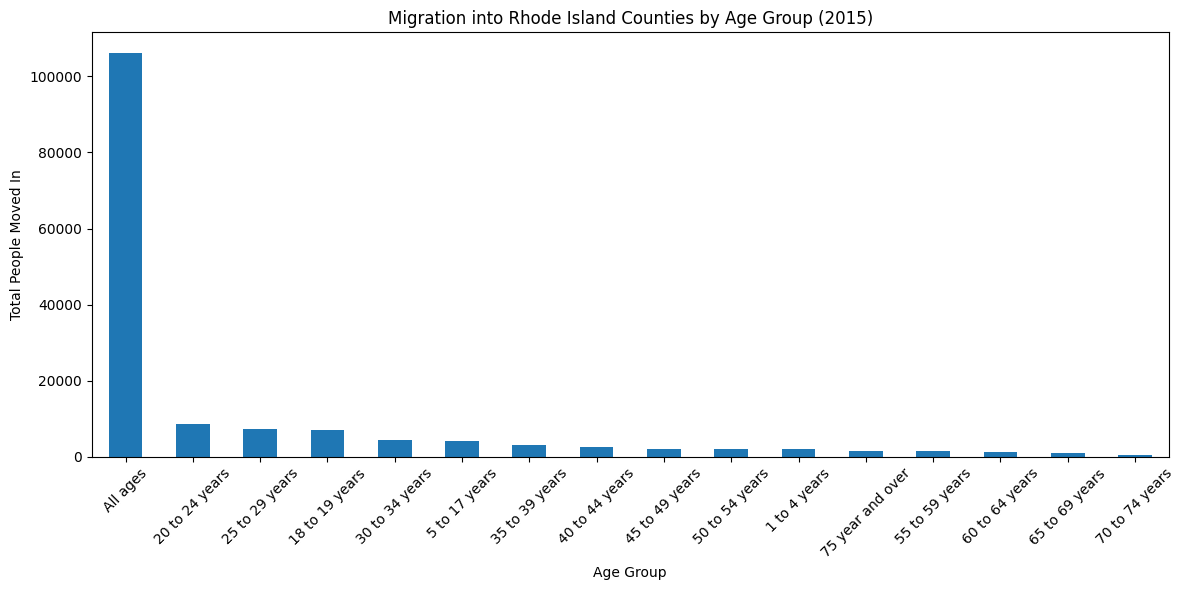

In [7]:
# Analyze migration by age group
if 'AGE_label' in ri_flows_breakdown.columns:
    age_migration = ri_flows_breakdown[ri_flows_breakdown['variable'] == 'MOVEDIN'].groupby('AGE_label')['estimate'].sum().sort_values(ascending=False)

    plt.figure(figsize=(12, 6))
    age_migration.plot(kind='bar')
    plt.title('Migration into Rhode Island Counties by Age Group (2015)')
    plt.xlabel('Age Group')
    plt.ylabel('Total People Moved In')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

## Metropolitan Statistical Area Flows

Migration flows are also available at the MSA level (2013+):

In [8]:
# Get MSA-level migration flows
msa_flows = tc.get_flows(
    geography="metropolitan statistical area",
    year=2018,
    output="wide"
)

print(f"MSA flows shape: {msa_flows.shape}")
msa_flows.head()

MSA flows shape: (70428, 10)


,GEOID1,GEOID2,FULL1_NAME,FULL2_NAME,MOVEDIN,MOVEDIN_M,MOVEDOUT,MOVEDOUT_M,MOVEDNET,MOVEDNET_M
0,10180,None,"Abilene, TX Metro Area",Outside Metro Area within U.S. or Puerto Rico,3883,508.0,2785.0,410.0,1098.0,684.0
1,10180,None,"Abilene, TX Metro Area",Africa,134,152.0,NaN,NaN,NaN,NaN
2,10180,None,"Abilene, TX Metro Area",Asia,504,207.0,NaN,NaN,NaN,NaN
3,10180,None,"Abilene, TX Metro Area",Central America,56,42.0,NaN,NaN,NaN,NaN
4,10180,None,"Abilene, TX Metro Area",Europe,264,176.0,NaN,NaN,NaN,NaN


In [9]:
# Find the largest MSA flows
largest_msa_flows = msa_flows.nlargest(10, 'MOVEDIN')
print("Largest MSA-to-MSA migration flows:")
for _, row in largest_msa_flows.iterrows():
    print(f"{row['FULL1_NAME']} → {row['FULL2_NAME']}: {row['MOVEDIN']:,} people")

Largest MSA-to-MSA migration flows:
Riverside-San Bernardino-Ontario, CA Metro Area → Los Angeles-Long Beach-Anaheim, CA Metro Area: 85,361 people
New York-Newark-Jersey City, NY-NJ-PA Metro Area → Asia: 65,239 people
Los Angeles-Long Beach-Anaheim, CA Metro Area → Asia: 57,528 people
Los Angeles-Long Beach-Anaheim, CA Metro Area → Riverside-San Bernardino-Ontario, CA Metro Area: 42,989 people
Dallas-Fort Worth-Arlington, TX Metro Area → Outside Metro Area within U.S. or Puerto Rico: 34,853 people
Philadelphia-Camden-Wilmington, PA-NJ-DE-MD Metro Area → New York-Newark-Jersey City, NY-NJ-PA Metro Area: 31,621 people
Washington-Arlington-Alexandria, DC-VA-MD-WV Metro Area → Asia: 31,025 people
Miami-Fort Lauderdale-West Palm Beach, FL Metro Area → Caribbean: 30,633 people
New York-Newark-Jersey City, NY-NJ-PA Metro Area → Europe: 29,904 people
San Francisco-Oakland-Hayward, CA Metro Area → Asia: 29,747 people


## Margin of Error and Confidence Levels

You can adjust the confidence level for margin of error calculations:

In [10]:
# Compare different confidence levels
flows_90 = tc.get_flows(geography="county", state="NY", year=2018, moe_level=90, output="wide")
flows_95 = tc.get_flows(geography="county", state="NY", year=2018, moe_level=95, output="wide")
flows_99 = tc.get_flows(geography="county", state="NY", year=2018, moe_level=99, output="wide")

print("Margin of error comparison for first flow:")
print(f"90% confidence: {flows_90['MOVEDIN_M'].iloc[0]:.1f}")
print(f"95% confidence: {flows_95['MOVEDIN_M'].iloc[0]:.1f}") 
print(f"99% confidence: {flows_99['MOVEDIN_M'].iloc[0]:.1f}")

Margin of error comparison for first flow:
90% confidence: 33.0
95% confidence: 39.3
99% confidence: 51.4


## Geometry Integration for Mapping

Add geographic centroids for mapping migration flows:

In [15]:
# Get flows with geometry
flows_geo = tc.get_flows(
    geography="county",
    state="FL",
    year=2018,
    geometry=True,
    output="wide"
)
flows_geo.tail()


Extracting tl_2022_us_county.zip...


/home/mmann1123/Documents/github/pytidycensus/pytidycensus/flows.py:538: UserWarning: Could not download county geography: File is not a zip file. Using placeholder centroids for all 6258 GEOIDs.
  warnings.warn(


,GEOID1,GEOID2,FULL1_NAME,FULL2_NAME,MOVEDIN,MOVEDIN_M,MOVEDOUT,MOVEDOUT_M,MOVEDNET,MOVEDNET_M,centroid1,centroid2
31800,12133,51810,"Washington County, Florida","Virginia Beach city, Virginia",14,23.0,0.0,28.0,14.0,23.0,POINT (-95 39),POINT (-95 39)
31801,12133,55061,"Washington County, Florida","Kewaunee County, Wisconsin",0,25.0,4.0,5.0,-4.0,5.0,POINT (-95 39),POINT (-95 39)
31802,12133,56021,"Washington County, Florida","Laramie County, Wyoming",0,25.0,8.0,13.0,-8.0,13.0,POINT (-95 39),POINT (-95 39)
31803,12133,3400557510,"Washington County, Florida","Pemberton township, Burlington County, New Jersey",0,25.0,4.0,6.0,-4.0,6.0,POINT (-95 39),POINT (-95 39)
31804,12133,5506162625,"Washington County, Florida","Pierce town, Kewaunee County, Wisconsin",0,25.0,4.0,5.0,-4.0,5.0,POINT (-95 39),POINT (-95 39)


In [12]:

print(f"Geometry-enabled flows shape: {flows_geo.shape}")
print(f"Geometry columns: {[col for col in flows_geo.columns if 'centroid' in col]}")
print(f"Is GeoDataFrame: {type(flows_geo)}")

if hasattr(flows_geo, 'geometry'):
    print(f"CRS: {flows_geo.crs}")
    flows_geo.head()

Geometry-enabled flows shape: (31805, 12)
Geometry columns: ['centroid1', 'centroid2']
Is GeoDataFrame: <class 'geopandas.geodataframe.GeoDataFrame'>
CRS: EPSG:4269


## Error Handling and Best Practices

Here are some common errors and how to handle them:

In [13]:
# Error: Invalid geography
try:
    tc.get_flows(geography="invalid", year=2018)
except ValueError as e:
    print(f"Geography error: {e}")

# Error: Year too early
try:
    tc.get_flows(geography="county", year=2009)
except ValueError as e:
    print(f"Year error: {e}")

# Error: Breakdown variables after 2015
try:
    tc.get_flows(geography="county", breakdown=["AGE"], year=2016)
except ValueError as e:
    print(f"Breakdown error: {e}")

# Error: MSA data before 2013
try:
    tc.get_flows(geography="metropolitan statistical area", year=2012)
except ValueError as e:
    print(f"MSA year error: {e}")

Geography error: Geography must be one of: county, county subdivision, metropolitan statistical area
Year error: Migration flows are available beginning in 2010
Breakdown error: Breakdown characteristics are only available for surveys before 2016
MSA year error: MSA-level data is only available beginning with 2013 (2009-2013 5-year ACS)


## Summary

The `get_flows()` function provides comprehensive access to Census migration flow data with features including:

- **Multiple geographic levels**: county, county subdivision, MSA
- **Flexible output formats**: wide (API format) or tidy (analysis-ready)
- **Demographic breakdowns**: age, sex, race, income, etc. (2006-2015 only)
- **Confidence levels**: 90%, 95%, or 99% for margin of error
- **Geometry integration**: centroids for mapping flows
- **Robust validation**: comprehensive error checking and helpful messages

For more information, see the [pytidycensus documentation](https://mmann1123.github.io/pytidycensus/).